# 1 - Time Domain Speech Analysis

In signal processing our main object of interest are discretised signals, in particular those living in the time domain.
Signals are functions from time to amplitude.
By measuring at evenly spaced points in time ("sampling") we obtain a sequence of amplitudes, the so called "samples".

Such a discretised signal thus comes with two important piees of data: The sequence of amplitudes (a vector of size `N`) and a sampling rate in Hz which tells us how many measurements take place per second.
To bundle this data we defined a datatype

```julia
# ./JuliaImpl/Audio.jl
struct Audio
    # indexed by [sample, track]
    samples      :: Array{Float64,2}

    # samples per second
    samplingRate :: Float64

    # timestamp of the first sample
    t0           :: Float64
end

```

The data type `Audio` is defined in `./JuliaImpl/Audio.jl` (module `SSP`) where we also provide various utility functions, such as

```julia
loadAudio(filepath::String)     # loads an Audio object from a WAVE soundfile

```


For this exercise we use the Julia package `Plots` to plot signals.
The interactive plots are provided by [plotly](https://plot.ly) while the static ones are provided by Python's [matplotlib](https://matplotlib.org/).

In [1]:
include("./JuliaImpl/SSP.jl")
include("./JuliaImpl/Sheet1.jl")
using Plots
using SSP

#plotly()  # enabling plotly for interactive plots
pyplot()  # enabling plotly for static plots and printing

Plots.PyPlotBackend()

Let's load two audio files.

In [2]:
speech1 = loadAudio("./Exercise1/speech1.wav")
speech2 = loadAudio("./Exercise1/speech2.wav")

SSP.Audio([0.000701926; -0.000244148; … ; 3.05185e-5; 3.05185e-5], 16000.0, 0.0)

## Fundamental Frequency Estimation by Eye

### (a)

```julia
samplingRate(audio::Audio)    # sampling rate of `audio`
```



In [3]:
println("The sampling rate for speech1.wav: ", samplingRate(speech1), " Hz")
println("The sampling rate for speech2.wav: ", samplingRate(speech2), " Hz")

The sampling rate for speech1.wav: 16000.0 Hz
The sampling rate for speech2.wav: 16000.0 Hz


### (b)

Given a signal the first measurement takes place at some time `audio.t0`.
The second measurement takes place after a certain period length `L` which is related to the sampling rate `samplingRate(audio)` via
`L * samplingRate(audio) = 1`.
By induction the `i`-th measurement takes place at time `t0 + (i-1)*L` which equals `audio.t0 + (i-1)/samplingRate(audio)`.

(CAVEAT: Julia adopted Matlab's convention of starting the indexing of vectors, matrices, etc. at 1)

The times at which the samples are measured are hence:

```julia
# ./JuliaImpl/Audio.jl
function times(audio::Audio)
    I = 1:numSamples(audio)
    audio.t0 + (I-1)/samplingRate(audio)
end

```

where

```julia
# ./JuliaImpl/Audio.jl
function numSamples(audio :: Audio)
    size(audio.samples)[1]
end
```

In [4]:
v_sample_time1 = times(speech1)
v_sample_time2 = times(speech2)

0.0:6.25e-5:2.86075

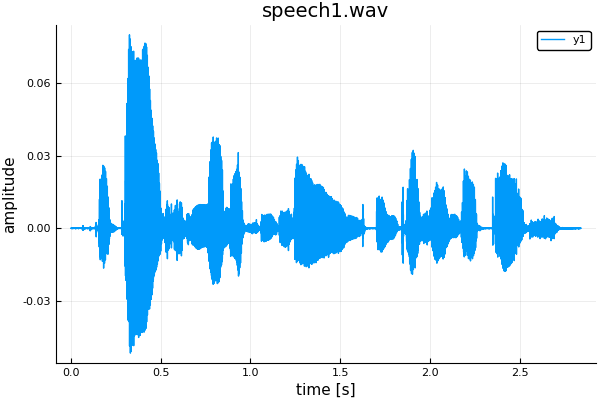

In [5]:
plot(v_sample_time1,speech1.samples[:,1],
    title="speech1.wav",xlab="time [s]",ylab="amplitude")

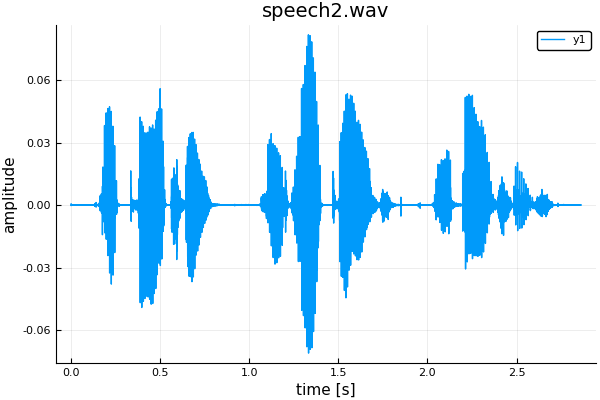

In [6]:
plot(v_sample_time2,speech2.samples[:,1],
    title="speech2.wav",xlab="time [s]",ylab="amplitude")

We can characterise three kinds of regions which can be observed in the signals:

- silent regions
    - have small amplitude
- voiced regions
    - consist of a periodic part multiplied by a varying amplitude
    - the variation of the amplitude happens at a slower scale and looks like a unimodal bump
    - such a bump contains about 10 to 20 periods (depending on fundamental frequency)
    - relatively large amplitude
- unvoiced regions
    - highly irregular at every scale
    - the amplitude's maxima vary more and don't look like unimodal bumps

### (c)

Estimation of the fundamental frequency for `speech1`
- Period from $t_0 = 0.3428125$ to $t_1 = 0.3478125$
- Frequency: $\frac{1}{t_1-t_0} \approx 200 Hz$
 
Estimation of the fundamental frequency for `speech2`
- Period from $t_0 = 0.6850625$ to $t_1 = 0.693$
- Frequency: $\frac{1}{t_1-t_0} \approx 126 Hz$

Calculation:

In [7]:
freqFromPeriod = function(from, to) 1/(to-from) end
println(freqFromPeriod(0.3428125, 0.3478125))
println(freqFromPeriod(0.6850625,0.693))

199.99999999999983
125.98425196850503


NOTE: To get better estimates we could have measured the length of $n$ periods and determined the mean period length.


## Block Processing

Given
- a signal `v_signal`
- a sampling rate `sampling_rate`
- the length of a time frame `frame_length`
- the distance between the starting points of two successive time frames `frame_shift`

The first task is to express the sizes of our time windows, which are given in seconds, in terms of number of samples.
This leads to the following definitions:

```julia
samples_per_frame = floor(Int, frame_length * sampling_rate)
```

```julia
samples_per_shift = floor(Int, frame_shift * sampling_rate)
```

Next we ask how many time frames fit into our signal.
It makes sense to assume that our signal contains at least one window.
The window following the first window _consumes_ from the remaining `length(v_signal) - samples_per_frame` samples precisely `samples_per_shift`.
In other words, we need to read `samples_per_shift` samples to construct the second time frame.
Continuing this process we obtain the formula

```julia
shift_count = 1 + Int(floor((length(v_signal) - samples_per_frame)/samples_per_shift))
```

We now know enough to fill the output matrix.

The center points of the time frames can be inferred as follows:
The center point of the first time frame is at `frame_length/2`.
Each following center point comes from a shift by `frame_shift`.

```julia
v_time_frame = frame_length/2 + frame_shift * (0:(shift_count-1))
```

```julia
# ./JuliaImpl/Sheet1.jl
function my_windowing(audio :: Audio;
                      frame_length = 32e-3 :: Float64,
                      frame_shift  = 16e-3 :: Float64)
    # number of samples per frame
    num_spf = floor(Int, frame_length * samplingRate(audio))
    # number of samples per shift
    num_sps = floor(Int, frame_shift * samplingRate(audio))
    # number of frames
    num_f   = 1 + floor(Int, (numSamples(audio) - num_spf)/num_sps)

    mean_time = frame_shift*(0:num_f-1) + frame_length/2
    m_frames = zeros(num_spf, numTracks(audio), num_f)
    for i in 1:num_f
        interval        = num_sps*(i-1) + (1:num_spf)
        m_frames[:,:,i] = audio.samples[interval,:]
    end

    FramedAudio(m_frames, samplingRate(audio), mean_time, num_spf, num_sps)
end

```

The output type of `my_windowing` is `FramedAudio`, which is defined in `./JuliaImpl/FramedAudio.jl`.

```julia
# ./JuliaImpl/FramedAudio.jl
struct FramedAudio
    # indexed by [sample, track, frame]
    frames        :: Array{Float64,3}

    # samples per second
    samplingRate :: Float64

    # average time of a frame
    mean_time     :: Array{Float64,1}

    # samples per frame
    spf           :: Int

    # samples per shift
    sps           :: Int
end
```

## Fundamental Frequency Estimator

### (a)

In [8]:
frames_speech1 = Sheet1.my_windowing(speech1,frame_length=32e-3,frame_shift=16e-3)
frames_speech2 = Sheet1.my_windowing(speech2,frame_length=32e-3,frame_shift=16e-3)

SSP.FramedAudio([0.000701926; -0.000244148; … ; 0.0; 3.05185e-5]

[3.05185e-5; 3.05185e-5; … ; -6.1037e-5; 0.000122074]

[0.0; 3.05185e-5; … ; 0.000152593; 0.0]

...

[0.0; 0.000152593; … ; -3.05185e-5; -6.1037e-5]

[-3.05185e-5; 3.05185e-5; … ; -6.1037e-5; -9.15555e-5]

[-3.05185e-5; 0.0; … ; 0.0; 0.0], 16000.0, [0.016, 0.032, 0.048, 0.064, 0.08, 0.096, 0.112, 0.128, 0.144, 0.16  …  2.688, 2.704, 2.72, 2.736, 2.752, 2.768, 2.784, 2.8, 2.816, 2.832], 512, 256)

### (b) & (c)

`autocor` can be implemented swiftly by defining `autocor = x -> xcorr(x,x)/length(x)`.

We provide a single function which can yield the whole autocorrelation as well as the truncated version which only allows non-negative shifts:

```julia
# ./JuliaImpl/Sheet1.jl
function autocor(x; truncate=false::Boolean)
    ac = xcorr(x,x)/length(x)
    truncate ? ac[length(x):end] : ac
end
```

### (d)

```julia
# ./JuliaImpl/Sheet1.jl
function fundamentalFrequencyEstimator(faudio::FramedAudio; track=1)
    # 80Hz:400Hz frequency window
    lb = floor(Int, samplingRate(faudio)/400)  # lower bound
    ub = ceil(Int, samplingRate(faudio)/80)   # upper bound

    # ff estimate per frame
    freq = zeros(numFrames(faudio))

    for j in 1:numFrames(faudio)
        # for simplicity we only analyse the first track
        ϕ = autocor(faudio.frames[:,track,j], truncate=true)
        ϕ[1:lb] = -Inf
        ϕ[ub:end] = -Inf
        freq[j] = samplingRate(faudio) / findmax(ϕ)[2]
    end

    return (faudio.mean_time, freq)
end
```

### (e)

We want to display our estimated fundamental frequency `ff` as well as the signal `s` within the same plot.
Because the units and scales between these data are vastly different, we tried to scale up the signal by a factor of `2000`.

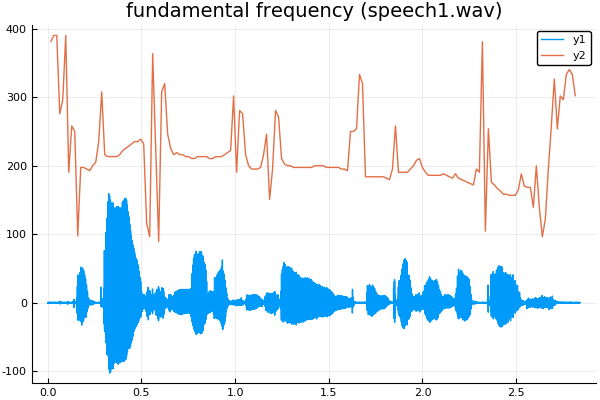

In [9]:
(tf1,ff1) = Sheet1.fundamentalFrequencyEstimator(Sheet1.my_windowing(speech1))
plot([v_sample_time1,tf1],[speech1.samples[:,1]*2000,ff1],
    title="fundamental frequency (speech1.wav)")

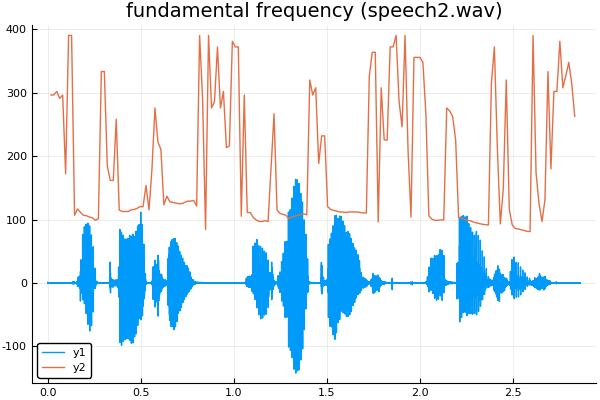

In [10]:
(tf2,ff2) = Sheet1.fundamentalFrequencyEstimator(Sheet1.my_windowing(speech2))
plot([v_sample_time2,tf2],[speech2.samples[:,1]*2000,ff2],
    title="fundamental frequency (speech2.wav)")

Remarks

- The base frequency estimator produces highly fluctuating values for voiceless or silent regions.
  This corresponds to our expectation that voiceless regions resemble white noise and that we do not find any striking peaks in the frequency domain.
- Voiced regions are usually flat.
  - However, this is not always the case: For the sound at 1.1s to 1.2s (speech2.wav) or at 2.2s to 2.3s (speech2.wav), the algorithm estimates between 100Hz and 300Hz.
  - For voiced regions, the fundamental frequency estimator seems to work more reliably with high pitched voices than with low pitched ones.
- The manually estimated frequency values (200Hz, 126Hz) correspond fairly well with the automatically estimated values (213Hz, 127Hz).

Further remarks
  
- A weakness of the estimation by means of autocorrelation is not only the peak determination but also the length and positioning of the time windows to which the autocorrelation is applied.
- One could first consider categorizing the time ranges into "voiced, voiceless, silent".
  This would allow us not to include the voiceless, noisy regions in the estimate.
- Furthermore, sounds are not purely periodic, but have an impulse-like, humpy part.
  Normalizing the amplitude could improve the estimates.